In [1]:
import os
import numpy as np

import skimage as ski
from skimage import io
from skimage import morphology as morph

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib as mpl

from sklearn.metrics import confusion_matrix

In [2]:
def plot_many (images2plot, nr_imgs, ordered = False):
    nr_rows = nr_imgs
    colors = ['black', 'orange', 'grey', 'white', 'white']
    bounds = [0, 1, 2, 3, 4]

    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    if len(np.shape(images2plot)) > 2 and np.shape(images2plot)[0] != 1:
        nr_imgs = np.shape(images2plot)[0]
        nr_cols = nr_imgs//nr_rows
    else:
        nr_cols = 1
    
    if (nr_cols == 1 and nr_rows == 1):
        fig = px.imshow(images2plot, color_continuous_scale='gray')
        fig.show()
    else:
        fig = plt.figure(figsize=(10*nr_cols,10*nr_rows))

        n = 1
        for i in range(nr_rows):
            for j in range(nr_cols):
                fig.add_subplot(nr_rows, nr_cols, n)
                if ordered:
                    index = n-1
                else:
                    index = i+(j*nr_rows)
                if np.max(images2plot[index] == 2):
                    plt.imshow(images2plot[index], cmap=cmap, norm=norm)
                    plt.axis('off')
                else:
                    plt.imshow(images2plot[index], cmap='gray')
                    plt.axis('off')
                n += 1
                if n > nr_imgs:
                    break
                    
        
        plt.show()

In [3]:
def plot_hists (images2plot, nr_rows=1, nbins=None):
    if (len(np.shape(images2plot)) == 2):
        fig = px.histogram(images2plot, nbins=nbins, color_discrete_sequence=['black'])
    else:
        nr_imgs = np.shape(images2plot)[0]
        nr_cols = nr_imgs//nr_rows

        fig = make_subplots(nr_rows, nr_cols)

        k = 0
        c = 1
        r = 1
        for k in range(nr_imgs):
            if (c > nr_cols):
                c=1
                r+=1
            fig.append_trace(go.Histogram(x=images2plot[k], nbins=nbins, color_discrete_sequence=['black']), r, c)
            c+=1
    fig.show()

In [4]:
def change_res(valor, shape):
    if isinstance(valor, list):
        for i in range(np.shape(valor)[0]):
            valor[i] = int(valor[i]*(shape/128))
    else:
        valor = int(valor*(shape/128))
        
    return valor

In [5]:
def normalize_img(img):
    if np.max(img-np.min(img)) == 0:
        return img
    else:
        return (img-np.min(img))/np.max(img-np.min(img))

In [6]:
def read_img(original_path, masks_path, shape, original_type, mask_type):
    # Declaration of storing variables
    originals = []
    masks = []
    
    # Definition of position to evaluate if image greyscale is inverted
    pos_x = shape[0]//2 + change_res(42, shape[0])
    pos_y = shape[1]//2
    var = change_res(3, shape[0])
    
    # Loop to read all images contained in original_path and their mask correspondents
    for filename in os.listdir(original_path):
        if os.path.isfile(os.path.join(original_path, filename)):
            print(filename)
            for p in [original_path, masks_path]:
                # Reads a mask
                if p == masks_path:
                    aux = io.imread(masks_path+filename[:-4] + "_mask" + mask_type)
                    
                    # cuts image to fit in a squared array (if necessary), rescales and normalizes it [0,1]
                    min_size = np.min([np.shape(aux)[0], np.shape(aux)[1]])
                    dif_x = abs(np.shape(aux)[0]-min_size)//2
                    dif_y = abs(np.shape(aux)[1]-min_size)//2
                    if (dif_x <= 0):
                        if (dif_y <= 0):
                            aux = normalize_img(ski.transform.resize(aux, shape))
                        else:
                            aux = normalize_img(ski.transform.resize(aux[:, dif_y:-dif_y], shape))
                    else:
                        if (dif_y <= 0):
                            aux = normalize_img(ski.transform.resize(aux[dif_x:-dif_x, :], shape))
                        else:
                            aux = normalize_img(ski.transform.resize(aux[dif_x:-dif_x, dif_y:-dif_y], shape))

                    aux = (aux >= np.max(aux))*1
                    
                    # if image has more than one channel, gets only one of them
                    if len(np.shape(aux))> 2:
                        masks += [aux[:, :, 0]]
                    else:
                        masks += [aux]
                        
                # Reads raw radiograph
                else:
                    # Reads an img type image
                    if (original_type == "IMG"):
                        fid = open(original_path+filename,'rb')
                        data = np.fromfile(fid,dt).reshape(original_shape)
                        originals += [ski.transform.resize(data/np.max(data), shape)]
                    # Reads other types of image
                    else:
                        aux = io.imread(original_path+filename)
                        # cuts image to fit in a squared array (if necessary), rescales and normalizes it [0,1]
                        min_size = np.min([np.shape(aux)[0], np.shape(aux)[1]])
                        dif_x = abs(np.shape(aux)[0]-min_size)//2
                        dif_y = abs(np.shape(aux)[1]-min_size)//2
                        if (dif_x <= 0):
                            if (dif_y <= 0):
                                aux = normalize_img(ski.transform.resize(aux, shape))
                            else:
                                aux = normalize_img(ski.transform.resize(aux[:, dif_y:-dif_y], shape))
                        else:
                            if (dif_y <= 0):
                                aux = normalize_img(ski.transform.resize(aux[dif_x:-dif_x, :], shape))
                            else:
                                aux = normalize_img(ski.transform.resize(aux[dif_x:-dif_x, dif_y:-dif_y], shape))

                        
                        # inverts image if lung region is darker than expected
                        if (aux[pos_x-var:pos_x+var, pos_y-var:pos_y+var].mean() > 0.5):
                            aux = ski.util.invert(aux)
                        
                        # if image has more than one channel, gets only one of them
                        if len(np.shape(aux))> 2:
                            originals += [aux[:, :, 0]]
                        else:
                            originals += [aux]
                            
    nr_imgs = np.shape(originals)[0]
                
    return originals, masks, nr_imgs

In [7]:
def identify_irregularities(margin_marker, original_img, shape, var, se_disk_7):
    # Identifies region out of patients' body
    s1 = morph.greyreconstruct.reconstruction(margin_marker*original_img, original_img)
    s2 = normalize_img(ski.exposure.adjust_sigmoid(s1, cutoff=0.7, gain=5))
    s3 = s2 < 0.5
    s4 = morph.remove_small_holes(s3, area_threshold=shape[0]//2)
    s5 = morph.erosion((s4 >= np.max(s4))*1, se_disk_7)
    
    # Finds neck
    s5_first_row = s5[1, :]
    neck_from_left = 1
    while(neck_from_left < len(s5_first_row) and s5_first_row[neck_from_left] == 0):
        neck_from_left+=1
    neck_from_right = shape[0]-1
    while(neck_from_right > 0 and s5_first_row[neck_from_right] == 0):
        neck_from_right-=1
    center_of_neck = (neck_from_right - neck_from_left)//2 + neck_from_left
    
    #Anulates trachea and vertebral column (if the position is close to the center of radiograph)
    s6 = np.ones(shape)
    if center_of_neck/shape[0] > 0.4 and center_of_neck/shape[0] < 0.6:
        s6[:, center_of_neck - var*4:center_of_neck + var*4] = 0
        
    # Histogram projection to eliminate noise in neck region
    err = 0.3
    
    s7 = morph.greyreconstruct.reconstruction(roi_marker*ski.util.invert(s1), ski.util.invert(s1))
    ## Left side
    sum_y0_l = s7[0:s7.shape[1]//4, 0: s7.shape[0]//2 - var].sum(axis = 1)
    y1 = 1
    initial_value = sum_y0_l[0]
    while((y1 < s7.shape[1]//4) and (sum_y0_l[y1] > ((1-err)*initial_value)) and (sum_y0_l[y1] < ((1+err)*initial_value))):
        y1 += 1
    
    ## Right side
    sum_y0_r = s7[0:s7.shape[1]//4, s7.shape[0]//2 - var: -1].sum(axis = 1)
    y2 = 1
    initial_value = sum_y0_r[0]
    while((y2 < s7.shape[1]//4) and (sum_y0_r[y2] > ((1-err)*initial_value)) and (sum_y0_r[y2] < ((1+err)*initial_value))):
        y2 += 1
        
    s8 = np.ones(shape)
    y = (y1 + y2)//2
    s8[0:y] = 0
    
    s9 = s5*s6*s8
    
    return [s1] + [s2] + [s7] + [s9], [s9]

In [8]:
def apply_conditional_dilation(img, se, shape, y_lim=0.75, x_lim=0.2):
    max_y = round(shape[0]*y_lim)
    
    max_x_left = round(shape[0]*x_lim)
    img[:max_y,:max_x_left] = morph.binary_dilation(img[:max_y,:max_x_left], se)
    
    min_x_right = round(shape[0]*(1-x_lim))
    img[:max_y,min_x_right:] = morph.binary_dilation(img[:max_y,min_x_right:], se)
    
    return img

In [9]:
def apply_conditional_erosion(img, se, shape, y_lim=0.75, x_lim=0.2):
    max_y = round(shape[0]*y_lim)
    
    max_x_left = round(shape[0]*x_lim)
    img[:max_y,:max_x_left] = morph.erosion(img[:max_y,:max_x_left], se)
    
    min_x_right = round(shape[0]*(1-x_lim))
    img[:max_y,min_x_right:] = morph.erosion(img[:max_y,min_x_right:], se)
    
    return img

In [10]:
def apply_morphology(img, shape, se):
    s1 = morph.area_opening(img,area_threshold=shape[0]*shape[0]//24)
    s2 = s1 >= np.max(s1)
    s3 = morph.remove_small_holes(s2,area_threshold=shape[0]//2)
    s4 = apply_conditional_dilation(s3, se, shape)    
    
    return [s1] + [s2] + [s3] + [s4], s4

In [11]:
def change_edges(img, size, value):
    img[:, :size] = value
    img[:, -size:] = value
    img[:size] = value
    img[-size:] = value
    return img

In [12]:
def calculate_CM(nr_imgs, results, mask):
    for i in range(nr_imgs):
        testing = results[i].flatten()*1
        validating = mask[i].flatten()*1
        
        tn, fp, fn, tp = confusion_matrix(validating, testing).ravel()
        metrics_sum = tn+fp+fn+tp
        print(
              'TP = {:.3f}'.format(tp/metrics_sum), 
              'FP = {:.3f}'.format(fp/metrics_sum), 
              'FN = {:.3f}'.format(fn/metrics_sum), 
              'TN = {:.3f}'.format(tn/metrics_sum), 
              'acc = {:.3f}'.format((tn+tp)/metrics_sum), 
              'jac = {:.3f}'.format(tp/(tp+fp+fn)),
              'sc_dice = {:.3f}'.format(2*tp/(2*tp+fp+fn)),
              'sens = {:.3f}'.format(tp/validating.sum()),   
              'spec = {:.3f}'.format(tn/(metrics_sum-validating.sum()))
             )

In [13]:
# Define reading paths and images' types
option = 1 # <--------------------------

if option == 1:
    original_path = os.getcwd() + '\\JSRT\\'
    masks_path = os.getcwd() + '\\JSRT_GTS\\'
    original_type = "IMG"
    mask_type = ".bmp"

else:
    original_path = os.getcwd() + '\\CHN\\'
    masks_path = os.getcwd() + '\\CHN_GTS\\'
    original_type = "png"
    mask_type = ".png"
    
# Parameters for img type
if (original_type == "IMG"):
    dt = np.dtype('>u2')
    original_shape = [2048, 2048]

# Definition of processing image resolution
shape = [128, 128]

# Definition of structuring elements based on processing resolution
se_disk_7 =  morph.disk(change_res(7, shape[0]))
se_rect_7_3 = morph.rectangle(change_res(7, shape[0]), change_res(3, shape[0]))
se_rect_14_3 = morph.rectangle(change_res(14, shape[0]), change_res(3, shape[0]))

# Definition of markers for reconstruction
roi_marker = np.zeros(shape)
pos_x = shape[0]//2 - change_res(21, shape[0])
pos_yu = shape[1]//2 + change_res(21, shape[0])
pos_yd = shape[1]//2 - change_res(21, shape[0])
var = change_res(1, shape[0])
roi_marker[pos_x-var:pos_x+var, pos_yu-var*change_res(5, shape[0]):pos_yu+var*change_res(5, shape[0])] = 1
roi_marker[pos_x-var:pos_x+var, pos_yd-var*5:pos_yd+var*5] = 1
roi_marker[pos_x-var*change_res(10, shape[0]):pos_x+var*change_res(10, shape[0]), pos_yu-var:pos_yu+var] = 1
roi_marker[pos_x-var*change_res(10, shape[0]):pos_x+var*change_res(10, shape[0]), pos_yd-var:pos_yd+var] = 1

margin_marker = np.zeros(shape)
margin_marker[0, :] = 1
margin_marker[-1, :] = 1
margin_marker[:, 0] = 1
margin_marker[:, -1] = 1

In [14]:
# Reads files
originals, masks, nr_imgs = read_img(original_path, masks_path, shape, original_type, mask_type)

JPCLN006.IMG
JPCLN008.IMG
JPCLN009.IMG
JPCNN001.IMG
JPCNN003.IMG
JPCNN005.IMG
JPCNN006.IMG
JPCNN008.IMG
JPCNN009.IMG
JPCNN010.IMG
JPCNN019.IMG
JPCNN020.IMG


In [15]:
all_steps = []
results = []
diffs = []

for i in range(nr_imgs):
    img = originals[i].copy()
    
    # Identifies irregularities
    irreg_steps, irreg_res = identify_irregularities(margin_marker, img, shape, var, se_disk_7)
    irreg_mask = irreg_res[0].copy()

    # Adjusts grey tone
    img_adjust = ski.util.invert(img*irreg_mask)
    img_adjust = normalize_img(ski.exposure.adjust_sigmoid(img_adjust, cutoff=0.6, gain=10))
    img_adjust = morph.closing(img_adjust, se_rect_7_3)
    img_adjust = ski.util.invert(img_adjust)
    img_adjust = change_edges(img_adjust, change_res(10, shape[0]), 0)
    
    # Binarizes
    thresh_mask = ski.filters.threshold_local(img_adjust, 2*shape[0]+1, 'gaussian')
    img_bin = img_adjust > thresh_mask

    # Applies morphology
    morph_steps, morph_res = apply_morphology(img_bin, shape, se_rect_14_3)
    res = morph_res.copy()
    
    diff = masks[i]+2*res
    
    # Stores steps' results for each image
    all_steps += [img]
    all_steps += irreg_steps
    all_steps += [img_adjust]
    all_steps += [img_bin]
    all_steps += morph_steps
    results += [res]
    diffs += [diff]

calculate_CM(nr_imgs, results, masks)

TP = 0.235 FP = 0.031 FN = 0.018 TN = 0.716 acc = 0.951 jac = 0.828 sc_dice = 0.906 sens = 0.928 spec = 0.959
TP = 0.337 FP = 0.036 FN = 0.015 TN = 0.612 acc = 0.949 jac = 0.869 sc_dice = 0.930 sens = 0.957 spec = 0.945
TP = 0.255 FP = 0.064 FN = 0.007 TN = 0.673 acc = 0.928 jac = 0.780 sc_dice = 0.876 sens = 0.972 spec = 0.913
TP = 0.335 FP = 0.075 FN = 0.003 TN = 0.587 acc = 0.922 jac = 0.811 sc_dice = 0.896 sens = 0.991 spec = 0.886
TP = 0.164 FP = 0.044 FN = 0.010 TN = 0.783 acc = 0.946 jac = 0.753 sc_dice = 0.859 sens = 0.942 spec = 0.947
TP = 0.317 FP = 0.057 FN = 0.025 TN = 0.600 acc = 0.918 jac = 0.794 sc_dice = 0.885 sens = 0.926 spec = 0.913
TP = 0.272 FP = 0.054 FN = 0.012 TN = 0.663 acc = 0.935 jac = 0.806 sc_dice = 0.893 sens = 0.959 spec = 0.925
TP = 0.272 FP = 0.028 FN = 0.035 TN = 0.666 acc = 0.938 jac = 0.813 sc_dice = 0.897 sens = 0.886 spec = 0.960
TP = 0.262 FP = 0.040 FN = 0.017 TN = 0.681 acc = 0.943 jac = 0.822 sc_dice = 0.902 sens = 0.939 spec = 0.945
TP = 0.304

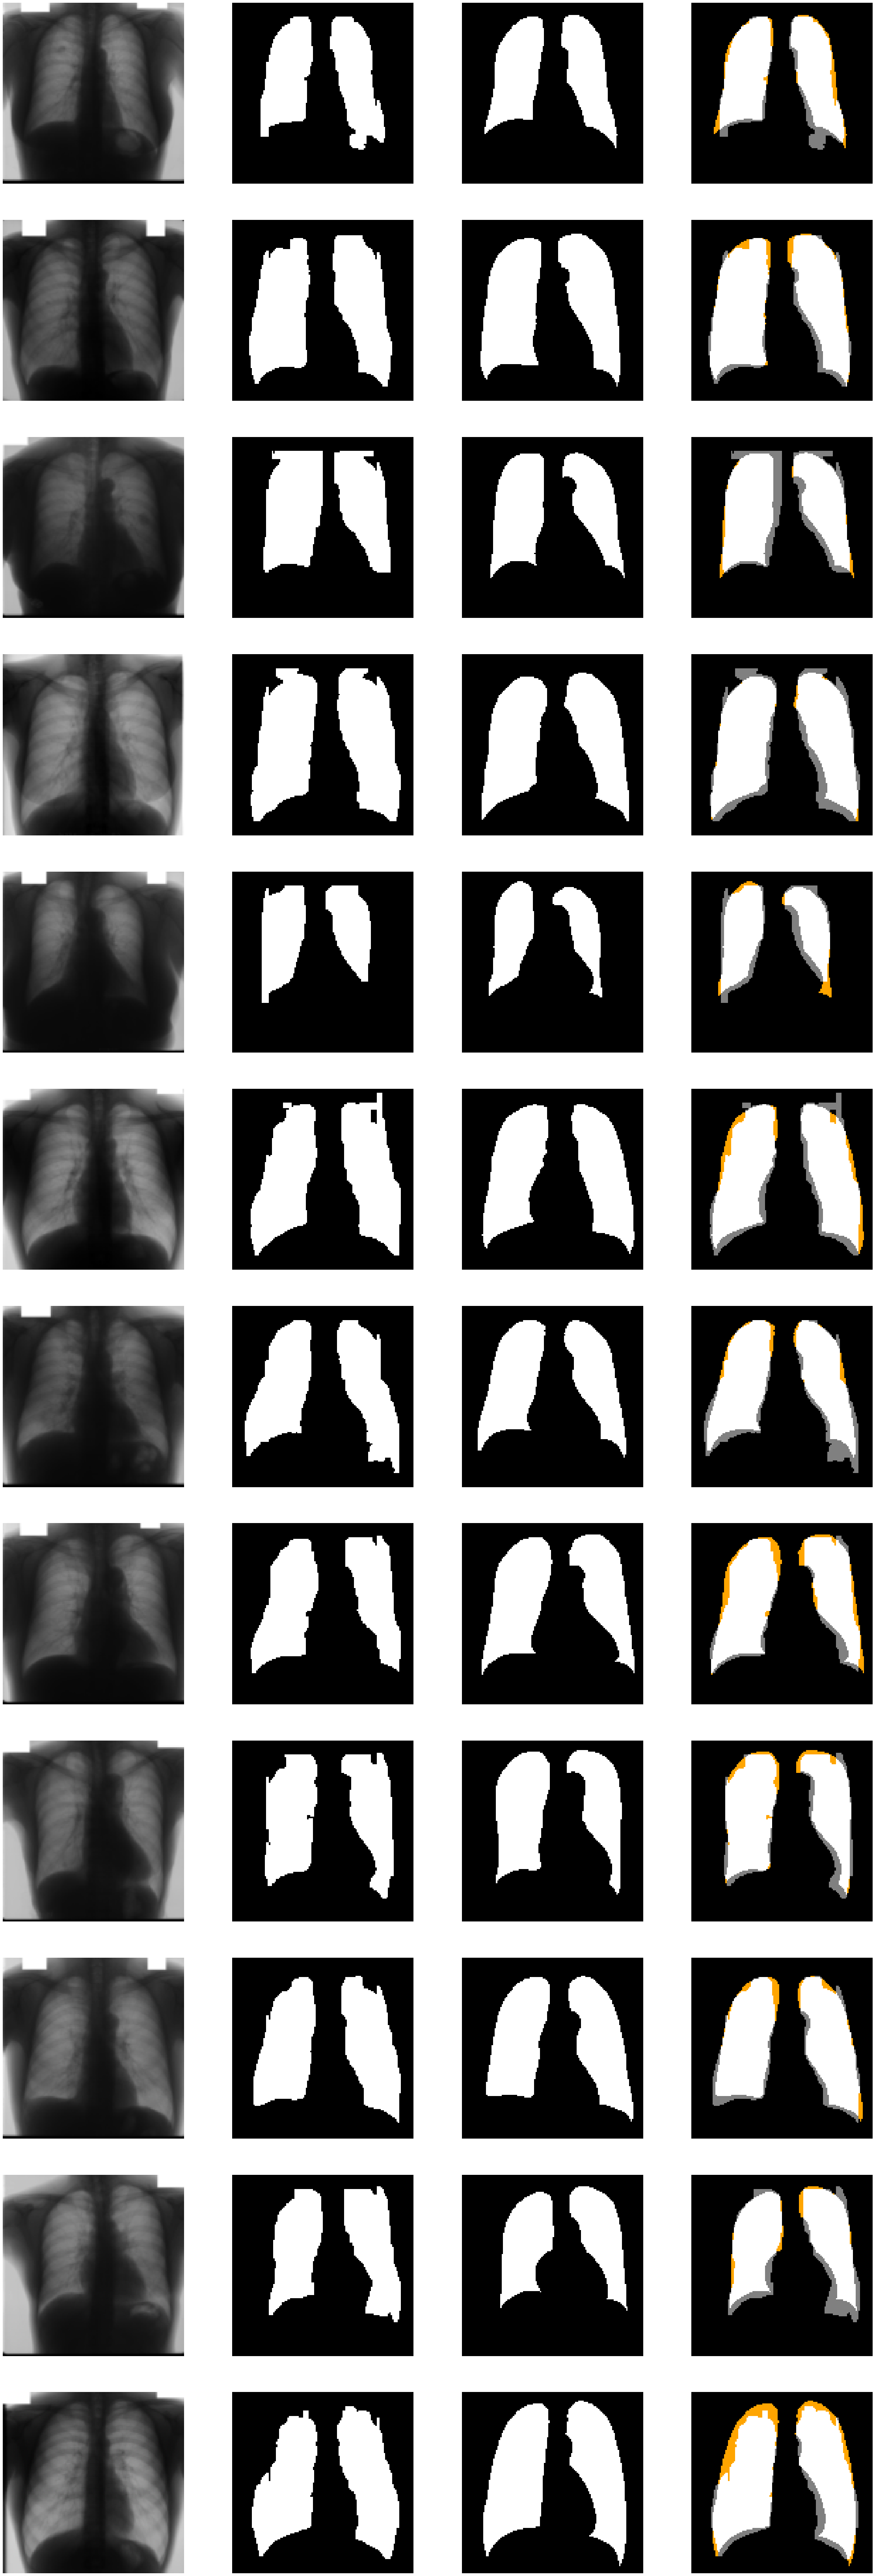

In [17]:
plot_many(originals+results+masks+diffs, nr_imgs)